# Imports

In [121]:
#!pip install obonet  numpy pandas matplotlib  sklearn python-bidi arabic_reshaper 

In [122]:
import requests,sys,math,pickle
import networkx,obonet
import numpy as np ,pandas as pd, matplotlib.pyplot as plt
import arabic_reshaper
import multiprocessing as mp
from sklearn.metrics.cluster import *
from bidi.algorithm import get_display
from functools import partial
from IPython.display import clear_output

In [123]:
def fa(text):
    return get_display(arabic_reshaper.reshape(u'%s' % str(text)))

In [124]:
num_cores = max(mp.cpu_count() - 3, 1)

# Load contigs dataset

In [127]:
# load anonymous contigs and save in contigs data frame.
path_contigs = "./Dataset/Gregor2016/simulated_dataset_uniform.fna"

with open(path_contigs, 'r') as file:
    lines = [line for line in file.read().split('\n') if len(line) > 0]    
    contigs = pd.DataFrame(
        {
            '#anonymous_gsa_id': lines[0::2],
            'contig': lines[1::2]
        },
        columns=['#anonymous_gsa_id', 'contig'])
    contigs['#anonymous_gsa_id'] = contigs['#anonymous_gsa_id'].apply(
        lambda x: x[1:])
del(lines)
contigs.head()

,#anonymous_gsa_id,contig
0,11543,CCGTGGAGATCATGTTCAGCGTCGTGAAGCCGTCGATGGCCTGGTA...
1,11546,GCAATGTTCCGGTGGTTCTTCGGGAACAGCGGGCCGACCAGGAGTC...
2,11544,CATAGAGTTGAGAGTCACAGTGATGGAACTGAAAGCCATGGCGAGT...
3,11545,CAAAAGCAGATGGCAGATTGAATTGTTCTTCAAATGGATAAAACAG...
4,11549,CTTGTGGATACGGGCAACGTGCTTTTTTGCTTTCAAGCGGTTGTTG...


In [128]:
# load gold standard file and append to contig data frame.
path_gold_standard = "./Dataset/Gregor2016/simulated_dataset_uniform.csv"
df = pd.read_csv(path_gold_standard, sep='\t', header=None)
df.columns = ['#anonymous_gsa_id', 'tax_id']
contigs = pd.merge(contigs, df, how='inner', on='#anonymous_gsa_id')
contigs["contig_length"] = contigs["contig"].apply(lambda x: len(x))
print(f'contigs number :  {contigs.shape[0]}')
print(f"number of genomes:  {len(contigs['tax_id'].unique())}")
del(df)
contigs.head(1)

contigs number :  14393
number of genomes:  47


,#anonymous_gsa_id,contig,tax_id,contig_length
0,11543,CCGTGGAGATCATGTTCAGCGTCGTGAAGCCGTCGATGGCCTGGTA...,369723,1394


##  Contigs description

min : 1000
max : 709034
mean : 9904.57
median : 3531.0
1st quartiles : 1779.0
median : 3531.0
3rd quartiles : 9100.0
standard deviation : 22002.54
variance : 484111797.66


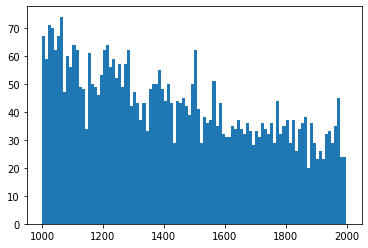

In [129]:
# show description of contigs and contigs length histogram.
contigsLenght = contigs['contig'].apply(lambda x: len(x))

print(f'min : {contigsLenght.min()}')
print(f'max : {contigsLenght.max()}')
print(f'mean : {round(contigsLenght.mean(),2)}')
print(f'median : {round(np.median(contigsLenght),2)}')
print(f'1st quartiles : {round(np.percentile(contigsLenght, 25),2)}')
print(f'median : {round(np.median(contigsLenght),2)}')
print(f'3rd quartiles : {round(np.percentile(contigsLenght, 75),2)}')
print(f'standard deviation : {round(np.std(contigsLenght),2)}')
print(f'variance : {round(np.var(contigsLenght),2)}')

plt.hist(contigsLenght[contigsLenght < 2000], bins=100)
plt.show()

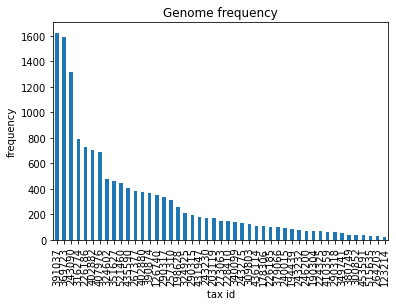

In [130]:
# show contig frequancy for every genome.
ax = contigs['tax_id'].value_counts().plot(kind='bar',
                                              title='Genome frequency')
plt.xlabel('tax id')
plt.ylabel('frequency')
plt.show()

In [131]:
# save gold standard data as CAMI binning Bioboxes format.
path_gold_standard_output = "./Output/Gregor2016/gold_standard.biobox"

contigs[['#anonymous_gsa_id', 'tax_id', 'tax_id',
         'contig_length']].to_csv(path_gold_standard_output, index=None, sep='\t')

with open(path_gold_standard_output, 'r') as file:
    file.readline()
    text = file.read()

with open(path_gold_standard_output, 'w', encoding='utf8') as file:
    file.write(
        "@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\tTAXID\t_LENGTH\n"
        + text)

## Busybee method with threshold 0%

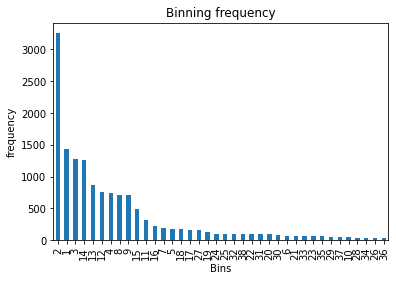

,#anonymous_gsa_id,contig,tax_id,contig_length,Busybee_bin0Percent
0,11543,CCGTGGAGATCATGTTCAGCGTCGTGAAGCCGTCGATGGCCTGGTA...,369723,1394,11


In [132]:
# read output of busybee method and append to contigs data frame.
path_busybee_0_percent = "./Binning/Gregor2016/Binning_busybee_0Percent/contigs.tab"
path_busybee_table_0_percent = "./Binning/Gregor2016/Binning_busybee_0Percent/binning/contigs.bin.table.tsv"

contig2Id = pd.read_csv(path_busybee_0_percent, sep='\t', header=None)
contig2Id.columns = ['#anonymous_gsa_id', 'id']

ID2Bin = pd.read_csv(path_busybee_table_0_percent, sep='\t', header=None)
ID2Bin.columns = ['id', 'Busybee_bin0Percent']

Busybee_bin = pd.merge(contig2Id, ID2Bin, how='outer', on='id')
Busybee_bin = Busybee_bin.drop(['id'], axis=1)

## merge contigs and genome_id
contigs = pd.merge(contigs, Busybee_bin, how='outer', on='#anonymous_gsa_id')
contigs['Busybee_bin0Percent'] = contigs['Busybee_bin0Percent'].fillna(0)

del(contig2Id, ID2Bin, Busybee_bin)
# show contigs frequancy of each bins.
ax = contigs['Busybee_bin0Percent'].value_counts().plot(
    kind='bar', title='Binning frequency')
plt.xlabel('Bins')
plt.ylabel('frequency')
plt.show()

contigs.head(1)

In [133]:
# save busybe 0% output as CAMI binning Bioboxes format
busybee_0_percent_output = "./Output/Gregor2016/Busybee_bin0Percent.biobox"

df = contigs[['#anonymous_gsa_id', 'Busybee_bin0Percent']]
df[df["Busybee_bin0Percent"] != 0].to_csv(busybee_0_percent_output,
                                          index=None,
                                          sep='\t')
with open(busybee_0_percent_output, 'r') as file:
    file.readline()
    text = file.read()
with open(busybee_0_percent_output, 'w', encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

## Busybee method with threshold 20%

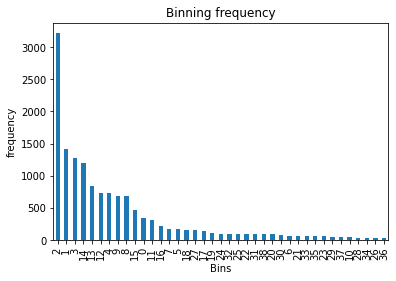

,#anonymous_gsa_id,contig,tax_id,contig_length,Busybee_bin0Percent,Busybee_bin20Percent
0,11543,CCGTGGAGATCATGTTCAGCGTCGTGAAGCCGTCGATGGCCTGGTA...,369723,1394,11,0


In [134]:
# read output of busybee method and append to contigs data frame.
busybee_20_percent = "./Binning/Gregor2016/Binning_busybee_20Percent/contigs.tab"
busybee_table_20_percent = "./Binning/Gregor2016/Binning_busybee_20Percent/binning/contigs.bin.table.tsv"

contig2Id = pd.read_csv(busybee_20_percent, sep='\t', header=None)
contig2Id.columns = ['#anonymous_gsa_id', 'id']

ID2Bin = pd.read_csv(busybee_table_20_percent, sep='\t', header=None)
ID2Bin.columns = ['id', 'Busybee_bin20Percent']

Busybee_bin = pd.merge(contig2Id, ID2Bin, how='outer', on='id')
Busybee_bin = Busybee_bin.drop(['id'], axis=1)

## merge contigs and genome_id
contigs = pd.merge(contigs, Busybee_bin, how='outer', on='#anonymous_gsa_id')
contigs['Busybee_bin20Percent'] = contigs['Busybee_bin20Percent'].fillna(0)

del(contig2Id, ID2Bin, Busybee_bin)

ax = contigs['Busybee_bin20Percent'].value_counts().plot(
    kind='bar', title='Binning frequency')
plt.xlabel('Bins')
plt.ylabel('frequency')
plt.show()

contigs.head(1)

In [135]:
#CAMI binning Bioboxes format
busybee_20_percent_output = "./Output/Gregor2016/Busybee_bin20Percent.biobox"

df = contigs[['#anonymous_gsa_id', 'Busybee_bin20Percent']]
df[df["Busybee_bin20Percent"] != 0].to_csv(busybee_20_percent_output,
                                           index=None,
                                           sep='\t')

with open(busybee_20_percent_output, 'r') as file:
    file.readline()
    text = file.read()
    
with open(busybee_20_percent_output, 'w', encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

## Busybee method with threshold 50%

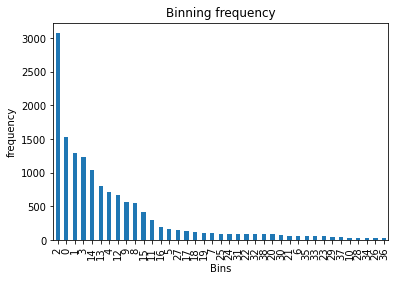

,#anonymous_gsa_id,contig,tax_id,contig_length,Busybee_bin0Percent,Busybee_bin20Percent,Busybee_bin50Percent
0,11543,CCGTGGAGATCATGTTCAGCGTCGTGAAGCCGTCGATGGCCTGGTA...,369723,1394,11,0,0


In [136]:
# read output of busybee method and append to contigs data frame.
busybee_50_percent = "./Binning/Gregor2016/Binning_busybee_50Percent/contigs.tab"
busybee_table_50_percent = "./Binning/Gregor2016/Binning_busybee_50Percent/binning/contigs.bin.table.tsv"

contig2Id = pd.read_csv(busybee_50_percent, sep='\t', header=None)
contig2Id.columns = ['#anonymous_gsa_id', 'id']

ID2Bin = pd.read_csv(busybee_table_50_percent, sep='\t', header=None)
ID2Bin.columns = ['id', 'Busybee_bin50Percent']

Busybee_bin = pd.merge(contig2Id, ID2Bin, how='outer', on='id')
Busybee_bin = Busybee_bin.drop(['id'], axis=1)

## merge contigs and genome_id
contigs = pd.merge(contigs, Busybee_bin, how='outer', on='#anonymous_gsa_id')
contigs['Busybee_bin50Percent'] = contigs['Busybee_bin50Percent'].fillna(0)

del(contig2Id, ID2Bin, Busybee_bin)
ax = contigs['Busybee_bin50Percent'].value_counts().plot(
    kind='bar', title='Binning frequency')
plt.xlabel('Bins')
plt.ylabel('frequency')
plt.show()
contigs.head(1)

In [137]:
#CAMI binning Bioboxes format
busybee_50_percent_output = "./Output/Gregor2016/Busybee_bin50Percent.biobox"
df = contigs[['#anonymous_gsa_id', 'Busybee_bin50Percent']]
df[df["Busybee_bin50Percent"] != 0].to_csv(busybee_50_percent_output,
                                           index=None,
                                           sep='\t')
with open(busybee_50_percent_output, 'r') as file:
    file.readline()
    text = file.read()
with open(busybee_50_percent_output, 'w', encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

# Gene Ontology
## https://www.ebi.ac.uk/QuickGO/api/index.html#/gene_ontology

In [262]:
annotation_go = "./Annotation/Gregor2016/data/cds.gene2go.tab.txt"
go = pd.read_csv(annotation_go,sep='\t')
print(f'gene2go table shape is : {go.shape}')
print(f'The number of contigs to which a GO term assigned is : {len(go["Contig"].unique())}')
print(f'The number of unique GO term assigned is : {len(go["TM"].unique())}')
go.head(1)

gene2go table shape is : (357169, 10)
The number of contigs to which a GO term assigned is : 41664
The number of unique GO term assigned is : 7093


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy
metaerg.pl|00002,6631,473,1252,780,1,No,0,GO:0004190,aspartic-type endopeptidase activity,d__Bacteria;p__Aquificota;c__Aquificae;o__Hydr...


In [263]:
annotation_go_profile = "./Annotation/Gregor2016/data/go.cds.profile.tab.txt"
go_profile = pd.read_csv(annotation_go_profile,sep='\t')
go_profile = go_profile.sort_values(by ='Count' ,ascending=False)
go_profile.head(1)

,#GO_id,Name,Count,Count_pct,Abund,Abund_pct
4857,GO:0005737,cytoplasm,14337,10.71,0,0


5.0


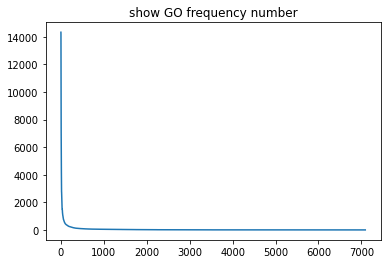

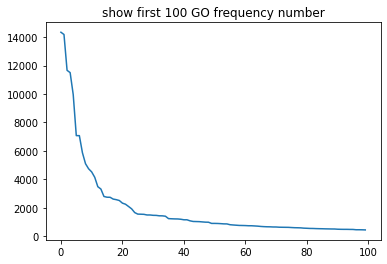

In [264]:
print(np.median(list(go['TM'].value_counts())))
plt.plot(list(go['TM'].value_counts()))
plt.title('show GO frequency number')
plt.show()

plt.plot(list(go['TM'].value_counts()[:100]))
plt.title('show first 100 GO frequency number')
plt.show()

## Add namespace [ cc, bp, mf ]

In [265]:
# function to get accession and return namespace
accession_to_namespace = dict()
go_graph = obonet.read_obo('./go.obo') 
go_ids = go['TM'].unique()
for accession in go_ids:
    try:        
        accession_to_namespace[accession] =  go_graph.nodes[accession]['namespace']
    except: # if not exist,store in list to get from API                                
        r = requests.get("https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/" + accession
                     , headers={ "Accept" : "application/json"})
        if not r.ok:
            print(f'Not found ', accession)                                              
        else:
            accession_to_namespace[accession]= r.json()['results'][0]['aspect']         

GO:0003996
GO:0015595
GO:0055114
GO:0023014
GO:0004003
GO:0048037
GO:0015991
GO:0008565
GO:0050662
GO:0005623
GO:0070011
GO:0042623
GO:0009108
GO:0004004
GO:0043140
GO:0051188
GO:0008026
GO:0043142
GO:0044212
GO:0102008
GO:0052143
GO:0043775
GO:0102017
GO:0015604
GO:0018192
GO:0045153
GO:0043725
GO:0043141
GO:0015672
GO:0015077
GO:0000784
GO:0000790
GO:0015321
GO:0103115
GO:0001047
GO:0071438
GO:0001017
GO:0102022
GO:0051187
GO:0051186
GO:0033317
GO:0072509
GO:0070838
GO:0090197
GO:0102908
GO:0102023
GO:0015623
GO:0015609
GO:0017091
GO:0038005
GO:0001150
GO:0043764
GO:0001302
GO:0070870
GO:0044415
GO:0045154
GO:0034459
GO:1902377
GO:0005724
GO:0033682
GO:0018307
GO:0044119
GO:0097679
GO:0048474
GO:0097756
GO:0052212
GO:0010204
GO:0032575
GO:1902478
GO:0044117
GO:0033680
GO:0030702
GO:0017127
GO:0001300
GO:0048365
GO:0052051


In [266]:
l = list()
def get_namespace(accession):
    if(accession in accession_to_namespace):        
        return accession_to_namespace[accession]
    l.append(accession)
    return None

go['Namespace'] = go['TM'].apply(lambda x : get_namespace(x) )
print(go['Namespace'].value_counts())
go.head(2)

molecular_function    173296
biological_process    117274
cellular_component     66599
Name: Namespace, dtype: int64


,#Gene,Contig,Start,End,Gene_Length,Strand,SP,TM,go_id,Taxonomy,Namespace
metaerg.pl|00002,6631,473,1252,780,1,No,0,GO:0004190,aspartic-type endopeptidase activity,d__Bacteria;p__Aquificota;c__Aquificae;o__Hydr...,molecular_function
metaerg.pl|00002,6631,473,1252,780,1,No,0,GO:0016020,membrane,d__Bacteria;p__Aquificota;c__Aquificae;o__Hydr...,cellular_component


# Our Method

## Create dictionary BP, CC , MF base of GOGO for each pair of go ids

In [351]:
def runGOGO(i,namespace):        
    %cd ./GOGO/
    !perl go_comb.pl ../Output/Gregor2016/{namespace}/go_ids{i}.txt ../Output/Gregor2016/{namespace}/go_ids_scores{i}
    %cd ..    

In [352]:
def Step1(namespace):
    !rm -r ./Output/Gregor2016/{namespace}/ & mkdir ./Output/Gregor2016/{namespace}/
    # first create all possible pairs of GOs for Biological Process
    go_ids = go[go["Namespace"] == namespace]['TM'].unique()    
    go1 = []
    go2 = []
    for i in range(0,go_ids.shape[0]):
        for j in range(i, go_ids.shape[0]):            
            go1.append(go_ids[i])
            go2.append(go_ids[j])
    df = pd.DataFrame({'goid1': go1,'goid2': go2},columns = ['goid1', 'goid2'])
    indexes = np.linspace(0,df.shape[0], num_cores + 1) // 1
    indexes[-1] =  df.shape[0]
    for i in range(0, num_cores):
        dfi = df.iloc[int(indexes[i]):int(indexes[i+1]),:]
        dfi.to_csv(f"./Output/Gregor2016/{namespace}/go_ids{i}.txt",sep=" ",index=None,header=None)
        
    # now run GOGO in multiprocessing
    if __name__ == '__main__':        
        pool = mp.Pool(num_cores)        
        pool.map(partial(runGOGO, namespace=namespace), range(0,num_cores))      
        
    clear_output()

In [353]:
def Step2(namespace):            
    def add2dict(row, dictionary):
        dictionary[row[0]+row[1]] = row[3]
        dictionary[row[1]+row[0]] = row[3]
        
    lines = []
    for i in range(0,num_cores):
        with open(f"./Output/Gregor2016/{namespace}/go_ids_scores{i}","r") as f:
            text = f.read()
            lines = [*lines, *[l for l in text.split("\n") if len(l) > 0 and l[-24:] != "not_in_the_same_ontology"]]                        
        
    with open(f"./Output/Gregor2016/{namespace}/go_ids_scores","w") as f:
        f.write('\n'.join(lines))    
    # create bp dictionary       
    df = pd.read_csv(f"./Output/Gregor2016/{namespace}/go_ids_scores", sep=" ", header=None)                
    dictionary = dict()    
    df.apply(lambda row:add2dict(row, dictionary), axis=1)
               
    with open(f"./Output/Gregor2016/{namespace}.pkl", "wb") as file:
        pickle.dump(dictionary, file)        
    !rm -r ./Output/Gregor2016/{namespace}/    

### Biological Process

In [354]:
namespace = "biological_process"
Step1(namespace)

In [355]:
Step2(namespace)

### Cellular Component

In [356]:
namespace = "cellular_component"
Step1(namespace)

In [357]:
Step2(namespace)

### Molecular Function

In [358]:
namespace = "molecular_function"
Step1(namespace)

In [359]:
Step2(namespace)

## Select unlabled contigs

In [360]:
unlabelled0 = contigs[contigs['Busybee_bin0Percent']==0] 
unlabelled20 = contigs[contigs['Busybee_bin20Percent']==0] 
unlabelled50 = contigs[contigs['Busybee_bin50Percent']==0]
n=contigs.shape[0];n0= unlabelled0.shape[0];n20=unlabelled20.shape[0];n50=unlabelled50.shape[0];
print(f'''Number of unlable for:
            bussybee 0% :     {n0}    {round(n0*100/n,2)}%
            bussybee 20% :    {n20}    {round(n20*100/n,2)}%
            bussybee 50% :    {n50}    {round(n50*100/n,2)}%''')

def contigs_with_go(df):
    return len(set(df['#anonymous_gsa_id']).intersection(set(go['Contig'])))

print(f'Contigs with go for: \t0% : {contigs_with_go(unlabelled0)}\t,20% : {contigs_with_go(unlabelled20)}\t,50% : {contigs_with_go(unlabelled50)}')

Number of unlable for:
            bussybee 0% :     0    0.0%
            bussybee 20% :    348    2.42%
            bussybee 50% :    1532    10.64%
Contigs with go for: 	0% : 0	,20% : 0	,50% : 0


## Load data

In [366]:
number_of_bins = int(max(contigs['Busybee_bin50Percent']))

bins = [0 for i in range(0,number_of_bins + 1)]

for i in range(0, number_of_bins):    
    cnt = contigs[contigs['Busybee_bin50Percent'] == (i+1)] # select contigs where bin_id = i    
    bins[i] = pd.merge(go, cnt, how="inner", 
                    left_on='#Gene',
                    right_on="#anonymous_gsa_id")['TM'].value_counts()        
    
with open("./Output/Gregor2016/biological_process.pkl", "rb") as file:
    bp_dictionary = pickle.load(file)

with open("./Output/Gregor2016/cellular_component.pkl", "rb") as file:
    cc_dictionary = pickle.load(file)
    
with open("./Output/Gregor2016/molecular_function.pkl", "rb") as file:
    mf_dictionary = pickle.load(file)

In [367]:
threshold = 0.2
alpha = 1  # BP
beta  = 1  # CC
gamma = 1  # MF

# this function recived a contig and return pred bin and score
def pred(cnt):                    
    def binScore(inp_bin, go_id,dictionary):
        scores = 0
        number = 0                
        for i in range(0, inp_bin.shape[0]):          
            pair = inp_bin.index[i] + go_id            
            if(pair in dictionary):                     
                n = inp_bin.values[i]
                scores += dictionary[pair] * n
                number += n
        if(number == 0):                
            return 0                  
        return scores / number
    
    sum_coefficient = 0    
    go_ids = go[go['#Gene'] == cnt]['TM']                    
    go_namespace =  go[go['#Gene'] == cnt]['Namespace']                
    
    result = np.zeros((go_ids.shape[0], number_of_bins))
    
    for i in range(0,len(go_ids.index)):              
        if(go_namespace[i] == "biological_process"):
            sum_coefficient += alpha
        if(go_namespace[i] == "cellular_component"):
            sum_coefficient += beta
        if(go_namespace[i] == "molecular_function"):
            sum_coefficient += gamma
                     
        for j in range(0, number_of_bins):                
            # Biological Process
            if(go_namespace[i] == "biological_process"):
                result[i,j] = binScore(bins[j], go_ids[i], bp_dictionary) * alpha            
                
            # Cellular Component
            if(go_namespace[i] == "cellular_component"):
                result[i,j] = binScore(bins[j], go_ids[i], cc_dictionary) * beta
                
            # Molecular Function
            if(go_namespace[i] == "molecular_function"):
                result[i,j] = binScore(bins[j], go_ids[i], mf_dictionary) * gamma                
    #         
    score = sum(result) / sum_coefficient          
    index = np.where(score == max(score))[0][0] + 1            
    return index, max(score), cnt    

In [372]:
if __name__ == '__main__':
    answer = {}        
    pool = mp.Pool(num_cores)    
    unlabelledContigs = pd.Series(list(set(unlabelled50['#anonymous_gsa_id']).intersection(set(go['#Gene']))))        
    for index, score, cnt in pool.map(pred,unlabelledContigs):        
        answer[cnt] = (index,  score)

In [393]:
def assign(row):
    cnt = row['#anonymous_gsa_id']
    if(cnt in answer and answer[cnt][1] > 0):                
        return answer[row['#anonymous_gsa_id']][0]    
    return row['Busybee_bin50Percent']
contigs['OurMethod'] = contigs.apply(lambda row:assign(row),axis=1)    

37
28
37
37
36
36
7
36
7
21
37
33
36
36
7
7
7
37
17
36
28
11
33
37
7
36
28
28
36
7
33
7
7
7
37
7
7
36
36
37
36
28
36
36
36
28
23
33
28
37
12
37
37
37
2
36
33
7
7
28
37
28
7
37
37
7
33
7
33
33
7
28
37
28
36
21
37
11
3
36
28
11
7
7
21
7
36
7
37
7
36
37
26
37
33
26
7
36
11
7
28
37
3
36
36
28
37
7
7
36
37
36
37
7
37
37
28
11
36
7
21
7
33
37
37
28
36
33
28
14
28
7
36
28
36
11
37
12
28
21
37
37
28
36
36
28
23
28
19
7
23
33
35
2
37
37
37
36
36
36
28
36
35
36
33
36
7
37
33
36
36
7
28
36
28
36
37
28
28
28
29
37
37
33
7
28
28
7
7
3
28
21
37
28
28
28
36
28
28
37
37
37
37
28
36
37
7
28
21
33
33
28
37
28
36
37
28
37
37
28
36
7
36
36
36
33
23
28
37
7
37
37
36
7
37
7
37
36
37
37
7
37
37
36
28
36
33
36
28
36
36
11
36
7
28
17
33
28
7
18
36
11
37
7
28
21
37
28
37
2
7
36
21
36
37
37
36
33
28
11
5
37
37
36
36
11
28
28
28
37
28
28
36
28
33
7
28
37
2
7
28
21
28
36
3
21
7
2
28
36
37
33
21
28
36
21
36
35
37
33
3
28
37
7
11
2
37
36
37
7
28
3
23
26
36
7
37
7
37
28
7
36
28
7
37
33
37
28
37
7
7
7
28
37
7
36
7
28


In [390]:
#CAMI binning Bioboxes format
OurMethod_output =  "./Output/Gregor2016/OurMethod.txt"

df = contigs[['#anonymous_gsa_id','OurMethod']]
df[df["OurMethod"]!= 0].to_csv(OurMethod_output,index=None, sep='\t')
with open(OurMethod_output,'r') as file:
    file.readline()
    text = file.read()
with open(OurMethod_output,'w',encoding='utf8') as file:
    file.write("@Version:0.9.1\n@SampleID:gsa\n\n@@SEQUENCEID\tBINID\n" + text)

In [391]:
!amber.py -g ./Output/Gregor2016/gold_standard.biobox -o ./Output/Gregor2016/Busybee/  ./Output/Gregor2016/Busybee_bin0Percent.biobox  ./Output/Gregor2016/Busybee_bin20Percent.biobox  ./Output/Gregor2016/Busybee_bin50Percent.biobox  ./Output/Gregor2016/OurMethod.txt

2021-05-02 04:11:17,835 INFO Loading Gold standard
2021-05-02 04:11:17,875 INFO Loading Busybee_bin0Percent.biobox
2021-05-02 04:11:17,912 INFO Loading Busybee_bin20Percent.biobox
2021-05-02 04:11:17,949 INFO Loading Busybee_bin50Percent.biobox
2021-05-02 04:11:17,983 INFO Loading OurMethod.txt
2021-05-02 04:11:18,019 INFO Creating output directories
2021-05-02 04:11:18,021 INFO Evaluating Gold standard (sample gsa, genome binning)
2021-05-02 04:11:18,204 INFO Evaluating Busybee_bin0Percent.biobox (sample gsa, genome binning)
2021-05-02 04:11:18,395 INFO Evaluating Busybee_bin20Percent.biobox (sample gsa, genome binning)
2021-05-02 04:11:18,585 INFO Evaluating Busybee_bin50Percent.biobox (sample gsa, genome binning)
2021-05-02 04:11:18,786 INFO Evaluating OurMethod.txt (sample gsa, genome binning)
2021-05-02 04:11:18,982 INFO Saving computed metrics
2021-05-02 04:11:19,019 INFO Creating genome binning plots
2021-05-02 04:11:39,309 INFO Creating HTML page
2021-05-02 04:11:41,268 INFO AM

# KEGG

In [ ]:
kegg = pd.read_csv('./Annotation/Toy_low/data/cds.gene2kegg.tab.txt',sep='\t')
print(kegg.shape)
kegg = pd.merge(kegg,Geneid2Contigid,how='inner',on='#Geneid')
kegg.head(2)

In [ ]:
print(np.median(list(kegg['Kegg_id'].value_counts())))
plt.plot(list(kegg['Kegg_id'].value_counts()))
plt.show()

# KO

In [ ]:
ko = pd.read_csv('./Annotation/Toy_low/data/cds.gene2ko.tab.txt',sep='\t')
print(ko.shape)
ko.head(5)

In [ ]:
print(np.median(list(ko['koid'].value_counts())))
plt.plot(list(ko['koid'].value_counts()))
plt.show()

In [ ]:
print(np.median(list(ko['Contig'].value_counts())))
plt.plot(list(ko['Contig'].value_counts()))
plt.show()

In [ ]:
df = pd.read_csv('./Annotation/Toy_low/data/cds.gene2sprot.tab.txt',sep='\t')
print(df.shape)
df.head(2)

In [ ]:
uniprot = pd.read_csv('./uniprot-filtered-reviewed-yes.tab',sep='\t')
print(uniprot.shape)
uniprot.head(2)

In [ ]:
df = pd.merge(uniprot,df,how='inner',left_on='Protein names',right_on='sprot_desc')
print(df.shape)
df.head(2)

# Gene id  to contig id maper

In [ ]:
with open('./Annotation/Toy_low/data/cds.faa', 'r') as file:     
    lines = [line.split('\n')[0] for line in file.read().split('>') if len(line) > 0]    
    data = {'#Geneid': [l.split(' ')[0] for l in lines],
        'Contigid': [l.split(' ')[-1][4:] for l in lines]}
    Geneid2Contigid = pd.DataFrame(data, columns = ['#Geneid', 'Contigid'])
Geneid2Contigid.head(2)

In [ ]:
plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000) ** 1, 'r')
plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000) ** 10, 'g')